<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/rnn_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

min = np.min(series)
max = np.max(series)
series -= min
series /= max
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



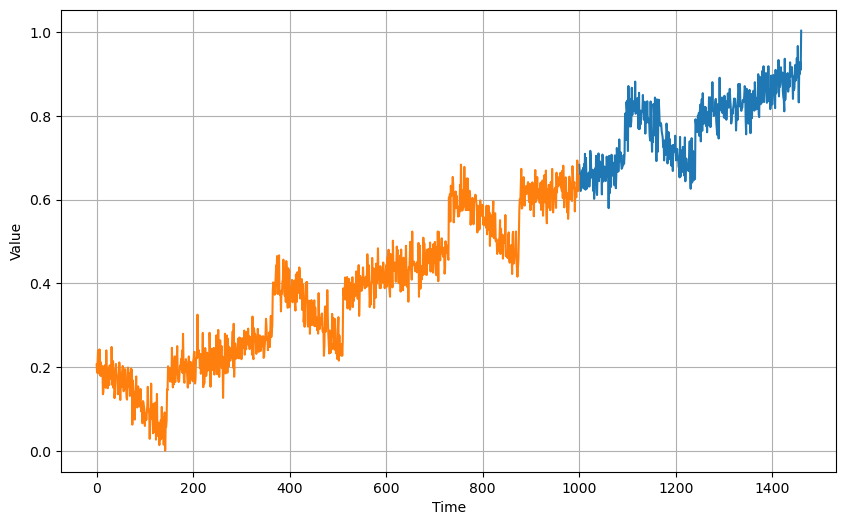

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_train, x_train)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 15
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5),
  tf.keras.layers.SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'), 
  tf.keras.layers.Dense(1),
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(), metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 [==============================] - 2s 71ms/step - loss: 0.3072 - mae: 0.3079
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 0.1815 - mae: 0.1816
Epoch 3/100
31/31 [==============================] - 1s 28ms/step - loss: 0.1548 - mae: 0.1549
Epoch 4/100
31/31 [==============================] - 1s 27ms/step - loss: 0.1305 - mae: 0.1305
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 0.1184 - mae: 0.1184
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 0.1032 - mae: 0.1033
Epoch 7/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0911 - mae: 0.0913
Epoch 8/100
31/31 [==============================] - 1s 26ms/step - loss: 0.0824 - mae: 0.0825
Epoch 9/100
31/31 [==============================] - 1s 27ms/step - loss: 0.0739 - mae: 0.0739
Epoch 10/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0656 - mae: 0.0657
Epoch 11/100
31/31 [=============================

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]

160.70773


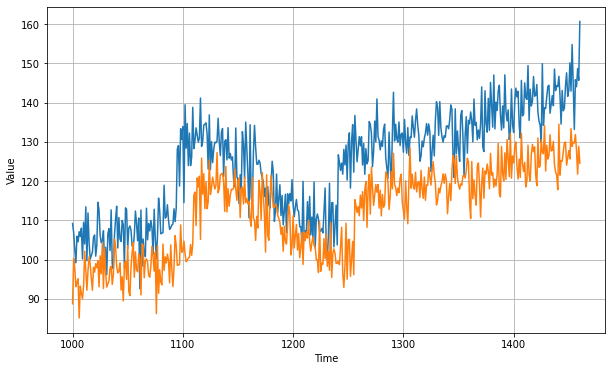

In [19]:
plt.figure(figsize=(10, 6))

#plot_series(time_valid, x_valid)
#plot_series(time_valid, forecast)

scaled_xvalid=x_valid*max
scaled_xvalid=scaled_xvalid+min
scaled_forecast=forecast*max
scaled_forecast=scaled_forecast+min

plot_series(time_valid, scaled_xvalid)
plot_series(time_valid, scaled_forecast)

print(max)


In [20]:
tf.keras.metrics.mean_absolute_error(scaled_xvalid, scaled_forecast).numpy()

array([35.71196  , 24.23442  , 26.71287  , 31.329697 , 30.180393 ,
       29.33767  , 39.323483 , 31.196878 , 33.050995 , 34.43038  ,
       31.158401 , 22.542894 , 27.10405  , 32.24465  , 27.267551 ,
       23.860933 , 25.703438 , 29.239569 , 32.260323 , 26.451002 ,
       27.648933 , 25.527954 , 26.530119 , 24.786741 , 31.383867 ,
       23.611511 , 28.095615 , 20.65648  , 31.80085  , 21.783566 ,
       27.849575 , 31.43986  , 30.639393 , 29.859192 , 26.667936 ,
       26.201893 , 30.771217 , 28.336985 , 19.855877 , 21.265224 ,
       26.24847  , 27.82945  , 27.427526 , 25.34164  , 32.21394  ,
       28.815332 , 34.975815 , 25.966166 , 24.899248 , 29.521036 ,
       21.215755 , 32.63771  , 33.6388   , 26.304832 , 22.966085 ,
       20.544104 , 28.95613  , 22.667055 , 27.069508 , 27.560202 ,
       23.23828  , 24.080908 , 33.446056 , 20.841682 , 21.133236 ,
       29.070948 , 24.790575 , 24.3354   , 25.208345 , 28.480341 ,
       28.93248  , 26.180887 , 21.432104 , 23.769125 , 27.4076